In [1]:
import numpy as np #useful for math
import pandas as pd #useful to represent data
from glob import glob #useful to get list of files
import os
import matplotlib.pyplot as plt
from intersac_tools import plot_ressac, get_sacintersac
from navipy.tools import extract_block
import tqdm
import multiprocessing
%matplotlib inline

We want to classify the trajectory of bumblebees as sequences of saccade and intersaccade:
* saccade: fast yaw rate 
* intersaccade: slow (ideally null) yaw rate

The data are noisy, therefore we will filter the yaw with a cspline (with free parameter lambda, chosen with cross-validation, here hard coded in the variable `lamb`). 

In [2]:
fps = 500

Due to noise, the yaw rate may fluctuate even during intersaccade. We therefore apply a threshold, at which an observed yaw rate is likely to be saccade:

In [3]:
threshold_1=0.013

And a second threshold, extending the span until the yaw rate is probably not comming from a saccade

In [4]:
threshold_2=0.007

In [5]:
#Define the parameters to extract Saccade and intersaccade
thresholds_head = [threshold_1, threshold_2]
np.rad2deg(thresholds_head)*fps

array([372.42256684, 200.5352283 ])

## Where are the data

In [6]:
# Load list of flights
head_filename_result = 'chapter_1_results/head_thorax_data.h5'
flight_ids = pd.read_hdf(head_filename_result,key='flight_ids')
# Load the results from splitted nonans
head_filename_result_blocknonans =  'chapter_1_results/head_thorax_data_blk.h5'

## Example

In [7]:
flightid = '17'
assert flightid in flight_ids.values, 'flight id unknwon'

blk_i = 0
key = '/blk_nonans/flight_{}'.format(flightid) 
blknonans = pd.read_hdf(head_filename_result_blocknonans,key)

assert blk_i in blknonans.index, 'Block unknown'

1) Load the data

In [8]:
key = '/trajectories_filtered/flight_{}/blk_{}'.format(flightid,blk_i) 
traj = pd.read_hdf(head_filename_result_blocknonans,key)
body_traj = traj.loc[:,'thorax']
head_traj = traj.loc[:,'head']

key = '/velocities_filtered/flight_{}/blk_{}'.format(flightid,blk_i) 
vel = pd.read_hdf(head_filename_result_blocknonans,key)
body_traj = pd.concat([body_traj,vel.loc[:,'thorax']],axis=1)
head_traj = pd.concat([head_traj,vel.loc[:,'head']],axis=1).dropna()
head_traj.head()

location                             zyx                      location  \
              x          y          z   alpha_0   alpha_1   alpha_2        dx   
337.0  8.840324 -55.978265  26.415362 -2.453275 -0.158637 -0.097742  0.034958   
338.0  8.631195 -55.823916  26.350140 -2.454454 -0.162206 -0.099876  0.064183   
339.0  8.349499 -55.606238  26.270804 -2.456198 -0.166602 -0.102817  0.080112   
340.0  8.028865 -55.337747  26.198864 -2.458453 -0.171191 -0.106241  0.077397   
341.0  7.697131 -55.030643  26.150214 -2.461282 -0.175634 -0.109832  0.060542   

                                zyx                      
             dy        dz  dalpha_0  dalpha_1  dalpha_2  
337.0 -0.137563 -0.009822  0.002201  0.000851 -0.000372  
338.0 -0.259741 -0.015084  0.003892  0.001423 -0.000834  
339.0 -0.355711 -0.009077  0.005027  0.001568 -0.001257  
340.0 -0.417049  0.012188  0.005514  0.001429 -0.001672  
341.0 -0.448519  0.043496  0.005543  0.001229 -0.002201

In [9]:
res_sac_head, blocksac_head=get_sacintersac(head_traj.zyx.dalpha_2, thresholds_head)

In [10]:
blocksac_head.head()

start_th1  end_th1  end_th2  start_th2
0      578.0    594.0    598.0      575.0
1      638.0    654.0    658.0      635.0
2      700.0    717.0    721.0      697.0
3      766.0    782.0    785.0      763.0
4      833.0    844.0    847.0      829.0

In [11]:
res_sac_head.head()

saccade intersac
337.0     NaN        0
338.0     NaN        0
339.0     NaN        0
340.0     NaN        0
341.0     NaN        0

In [12]:
nonanhead = head_traj.dropna().index

## Thorax

In many experiments, the recording of the head orientation is not feasible. Thus, researchers have estimated the saccade/intersaccade sequences based on the yaw rate of the body. However, the body turns at less pronounce angular velocity than the head. Therefore, choosing the two tresholds is difficult. 

Here, we choose the threshold for the body in an "optimal" manner to later compare alternative method for saccade/intersaccade sequence extraction. Indeed we know the saccade/intersaccade states of the bee by observing the head yaw rate. Thus, we can choose the threshold such as to maximise the accuracy of the saccade/intersaccade classification.

To score the classification, we use the accuracy because our classes (intersaccade, saccade) are relatively well balanced.

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
body_traj = body_traj.loc[nonanhead,:]

Extract with head threshold first

In [15]:
res_sac_body,_ = get_sacintersac(body_traj.zyx.dalpha_2, thresholds_head)

We will do a grid search from the median of absdiv to 5 times the standard deviation of absdiv

In [16]:
absdiv = np.abs(body_traj.zyx.dalpha_2)
thbodys_1 = np.linspace(threshold_1/10,threshold_1,151)
thbodys_2 = np.linspace(threshold_1/10,threshold_1,151)
[m1,m2]=np.meshgrid(thbodys_1,thbodys_2)
m1 = m1.flatten()
m2 = m2.flatten()
grid_thresholds_body = pd.DataFrame(index=np.arange(m1.shape[0]),
                               columns=['th1','th2'])
grid_thresholds_body.th1 = m1
grid_thresholds_body.th2 = m2
tokeep = grid_thresholds_body.th1<=grid_thresholds_body.th2
grid_thresholds_body = grid_thresholds_body.loc[tokeep,:]

grid_thresholds_body['Sum'] = grid_thresholds_body.th1+grid_thresholds_body.th2
grid_thresholds_body.sort_values(by='Sum', ascending=False, inplace=True)
grid_thresholds_body.reset_index(inplace=True)
grid_thresholds_body.drop(['index','Sum'],axis=1, inplace=True)
grid_thresholds_body.head()

th1       th2
0  0.013000  0.013000
1  0.012922  0.013000
2  0.012844  0.013000
3  0.012922  0.012922
4  0.012766  0.013000

We define a function that will return the thresholds for the body with highest score

In [17]:
def get_best_th(omegaz,grid_thresholds_body,res_sac_head,verbose=False):
    bestscore = -np.inf
    bestrow_i = np.nan
    saccade_class_ref = res_sac_head.saccade.isnull()
    for row_i, row in grid_thresholds_body.iterrows():
        # Extract body saccade with thresholds
        res_sac_body,_ = get_sacintersac(omegaz, np.sort(row.values)[::-1])
        # True false of intersaccade class
        saccade_class = res_sac_body.saccade.isnull()
        score = accuracy_score(saccade_class_ref, saccade_class)
        #print(row.values, score)
        if score>bestscore:
            if verbose:
                print(np.sort(row.values)[::-1], score)
            bestscore=score
            bestrow_i=row_i
    thresholds_body=np.sort(grid_thresholds_body.loc[bestrow_i].values)[::-1]
    return thresholds_body, bestscore

Hard coded Time estimate 

In [18]:
time_e = 0.086
print('It will take ',time_e*grid_thresholds_body.shape[0], 'sec')

It will take  986.9359999999999 sec


In [19]:
thresholds_body, score=get_best_th(body_traj.zyx.dalpha_2,grid_thresholds_body,res_sac_head)
print(score)
res_sac_body,blocksac_body=get_sacintersac(body_traj.zyx.dalpha_2, thresholds_body)
thresholds_body

0.8154111558366878


array([0.012454, 0.01144 ])

#### Visualisation

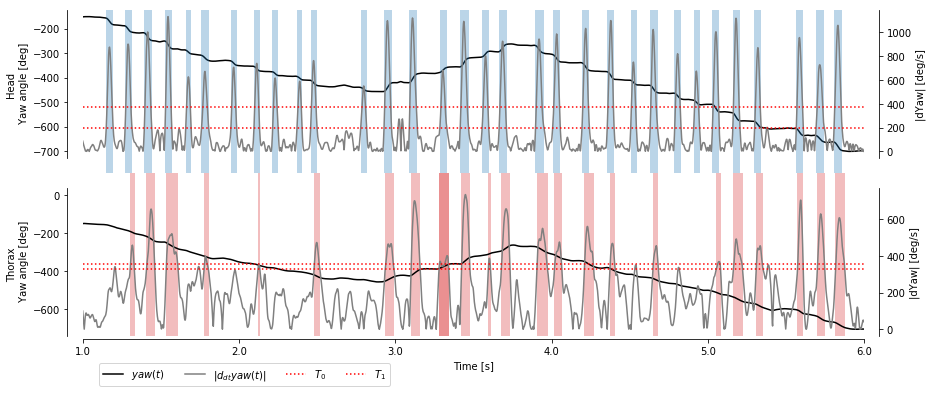

In [20]:
fps = 500
idx = np.arange(500,3000)
fig,axarr = plt.subplots(2,1,sharex=True,figsize=(14,6))
res_sac_head['filtered'] = head_traj.zyx.alpha_0
res_sac_head['first_deriv'] = head_traj.zyx.dalpha_2
ax1,ax2=plot_ressac(axarr[0], res_sac_head.astype(float),blocksac_head,idx, thresholds_head, facecolor='C0')
ax1.set_ylabel('Head \n Yaw angle [deg]')
for ax in [ax1, ax2]:
    ax.spines['top'].set_color(None)
    ax.spines['bottom'].set_color(None)
ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['left'].set_color(None)
ax2.spines['right'].set_position(('axes', +1.02))
ax1.spines['right'].set_color(None)
ax1.xaxis.set_ticks_position('none')

res_sac_body['filtered'] = body_traj.zyx.alpha_0
res_sac_body['first_deriv'] = body_traj.zyx.dalpha_2
ax1,ax2=plot_ressac(axarr[1], res_sac_body.astype(float),blocksac_body,idx, thresholds_body, facecolor='C3')
ax1.set_ylabel('Thorax \n Yaw angle [deg]')
ax1.set_xlabel('Time [s]')
ax1.set_xlim(min(idx),max(idx))
for ax in [ax1, ax2]:
    ax.spines['top'].set_color(None)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_color(None)
ax2.spines['left'].set_color(None)
ax2.spines['right'].set_position(('axes', +1.02))
ax1.spines['right'].set_color(None)
ax1.set_xticklabels(['{}'.format(f/fps) for f in ax1.get_xticks()])
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h1.extend(h2)
l1.extend(l2)
#ax2.legend(ncol=3)
ax1.legend(handles=h1, labels=l1, ncol=4, loc=0, bbox_to_anchor=(0.40, -0.15))
ax1.set_facecolor((0,0,0,0))

import matplotlib.transforms as mtransforms
trans1 = mtransforms.blended_transform_factory(
    ax1.transData, ax1.transAxes)
for iii, (color, ys, blocksac) in enumerate(zip(['C0','C3'],
                                         [(2.2,1.1),(1.1,0)],
                                         [blocksac_head, blocksac_body])):
    for i, row in blocksac.iterrows():
        if (row.start_th2 < min(idx)) or (row.start_th2 > max(idx)):
            continue
        ax1.fill_between([row.start_th2, row.end_th2], min(ys), max(ys), facecolor=color,
                         alpha=0.3, transform=trans1, linewidth=0, clip_on=False, edgecolor=None)   

Concatenate

In [21]:
thresholds = pd.DataFrame(np.vstack([thresholds_head, thresholds_body]), index=['head','thorax'], columns=['high','low'])
res_sac = pd.concat([res_sac_head,res_sac_body], axis=1, keys=['head','thorax'])
blocksac = pd.concat([blocksac_head,blocksac_body], axis=1, keys=['head','thorax'])

## For all

In [22]:
def process(inputs, thresholds_head=thresholds_head):
    #unwrap inputs
    flightid,blk_i = inputs
    # 1) load the data
    key = '/velocities_filtered/flight_{}/blk_{}'.format(flightid,blk_i) 
    traj = pd.read_hdf(head_filename_result_blocknonans,key)
    body_traj = traj.loc[:,'thorax']
    head_traj = traj.loc[:,'head'].dropna()
    nonanhead = head_traj.dropna().index
    body_traj = body_traj.loc[nonanhead,:]
    # 2) extract head saccade
    res_sac_head, blocksac_head=get_sacintersac(head_traj.zyx.dalpha_2, thresholds_head)
    
    # 3) Extract body saccade with head thresholds
    res_sac_body,_ = get_sacintersac(body_traj.zyx.dalpha_2, thresholds_head)
    
    # 4) Define grid
    absdiv = np.abs(body_traj.zyx.dalpha_2)
    thbodys_1 = np.linspace(threshold_1/10,threshold_1,151)
    thbodys_2 = np.linspace(threshold_1/10,threshold_1,151)
    [m1,m2]=np.meshgrid(thbodys_1,thbodys_2)
    m1 = m1.flatten()
    m2 = m2.flatten()
    grid_thresholds_body = pd.DataFrame(index=np.arange(m1.shape[0]),
                                   columns=['th1','th2'])
    grid_thresholds_body.th1 = m1
    grid_thresholds_body.th2 = m2
    tokeep = grid_thresholds_body.th1<=grid_thresholds_body.th2
    grid_thresholds_body = grid_thresholds_body.loc[tokeep,:]

    grid_thresholds_body['Sum'] = grid_thresholds_body.th1+grid_thresholds_body.th2
    grid_thresholds_body.sort_values(by='Sum', ascending=False, inplace=True)
    grid_thresholds_body.reset_index(inplace=True)
    grid_thresholds_body.drop(['index','Sum'],axis=1, inplace=True)
    
    # Grid search
    thresholds_body, score=get_best_th(body_traj.zyx.dalpha_2,grid_thresholds_body,res_sac_head)
    
    # 5) Extract body saccade
    res_sac_body,blocksac_body=get_sacintersac(body_traj.zyx.dalpha_2, thresholds_body)
    
    # 6) Concat
    thresholds = pd.DataFrame(np.vstack([thresholds_head, thresholds_body]), index=['head','thorax'], columns=['high','low'])
    res_sac = pd.concat([res_sac_head,res_sac_body], axis=1, keys=['head','thorax'])
    blocksac = pd.concat([blocksac_head,blocksac_body], axis=1, keys=['head','thorax'])
    
    return flightid, blk_i, thresholds, res_sac, blocksac

List all blocks with their corresponding flight id


In [8]:
inputs = []
for flightid in flight_ids.values:
    key = '/blk_nonans/flight_{}'.format(flightid) 
    blknonans = pd.read_hdf(head_filename_result_blocknonans,key)
    for blk_i in blknonans.index:
        inputs.append((flightid, blk_i))

Loop through all rec

In [24]:
pool = multiprocessing.Pool()
results = list()
# This will show the progress
for res in tqdm.tqdm(pool.imap_unordered(process, inputs), total=len(inputs)):
    results.append(res)
pool.close()
pool.join()
# Save the results after themultiprocessing
# because we cannot read and save in threadsafe manner (without locks)
for res in results:
    flightid, blk_i, thresholds, res_sac, blocksac = res 
    # 4 - Save
    with pd.HDFStore(head_filename_result_blocknonans,'a') as hdfile:
        key = 'thresholds/flight_{}/blk_{}'.format(flightid, blk_i)
        hdfile.put(key,thresholds.astype(float))
        key = 'res_sac/flight_{}/blk_{}'.format(flightid, blk_i)
        hdfile.put(key,res_sac.astype(float))
        key = 'blocksac/flight_{}/blk_{}'.format(flightid, blk_i)
        hdfile.put(key,blocksac.astype(float))

100%|██████████| 22/22 [1:22:03<00:00, 223.81s/it]
